## Predict Future Sales

### Import libraries
It should work with Python 3.8. 
Tested on 9/.26/2021  Yifan Zhang

In [9]:
!pip install lightgbm
!pip install tabulate


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgb
import xgboost as xgb
import pickle
import gc

for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm,tqdm_notebook

from xgboost import plot_tree
from xgboost import plot_importance
from xgboost import XGBRegressor
from matplotlib import pyplot

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor


numpy 1.18.5
pandas 1.0.5
sklearn 1.0
lightgbm 3.2.1


In [11]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.18.5
pandas 1.0.5
sklearn 1.0
lightgbm 3.2.1


In [12]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Load Dataset

In [13]:
sales = pd.read_csv('Dataset/sales_train.csv')
shops = pd.read_csv('Dataset/shops.csv')
items = pd.read_csv('Dataset/items.csv')
items_categories = pd.read_csv('Dataset/item_categories.csv')
sample_submission = pd.read_csv('Dataset/sample_submission.csv')
test_data = pd.read_csv('Dataset/test.csv')

In [14]:
sales.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1


## Part 1. Exploratory Data Analysis
Visualize the data, plot trends, discard and impute outliers
Organize the data to establish training set

### Number of items per category

In [15]:
items_per_category = items.item_category_id.value_counts().iloc[:10]
items_per_category = items_per_category.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Number of items per category')

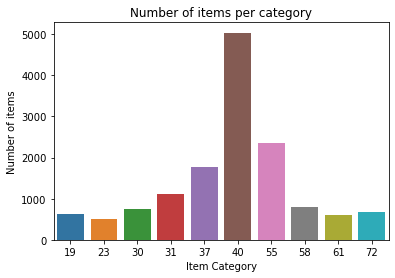

In [16]:
sns.barplot(items_per_category.index, items_per_category.values)
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

### Popular shops based on item count in the last 33 months

In [17]:
popular_shops = sales.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:5]

Text(0.5, 1.0, 'Popular shops')

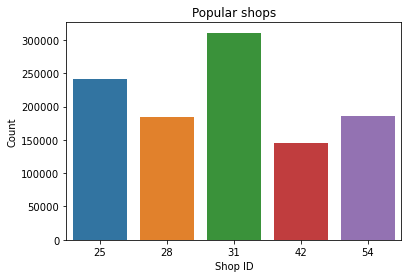

In [18]:
sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

- "31" is the shop that sold more number of items in the last 33 months.

### Popular items based on item count in the last 33 months

In [19]:
popular_items = sales.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:5]

Text(0.5, 1.0, 'Popular items')

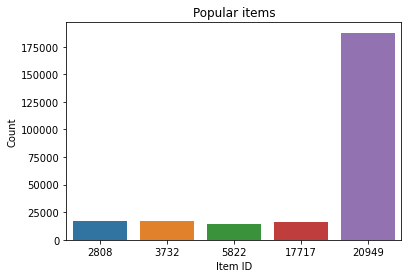

In [20]:
sns.barplot(popular_items.index, popular_items.values)
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Popular items")

- "20949" is the item that was sold more number of items in the last 33 months.

### Count of items sold in each month

In [21]:
item_cnt_month = sales.groupby('date_block_num')['item_cnt_day'].sum()

Text(0.5, 1.0, 'Number of items sold in each month')

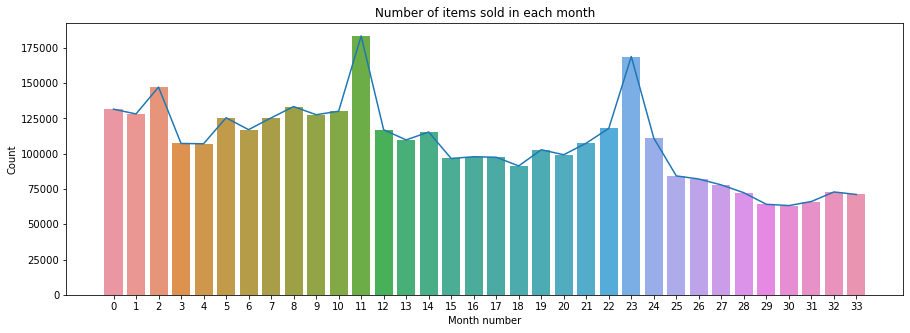

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

- At the end, the number of items sold are decreasing.
- The highest number of items that are sold in 11th month.

### Total price of items sold in each month

In [23]:
price_cnt_month = sales.groupby('date_block_num')['item_price'].sum()

Text(0.5, 1.0, 'Total price of items sold in each month')

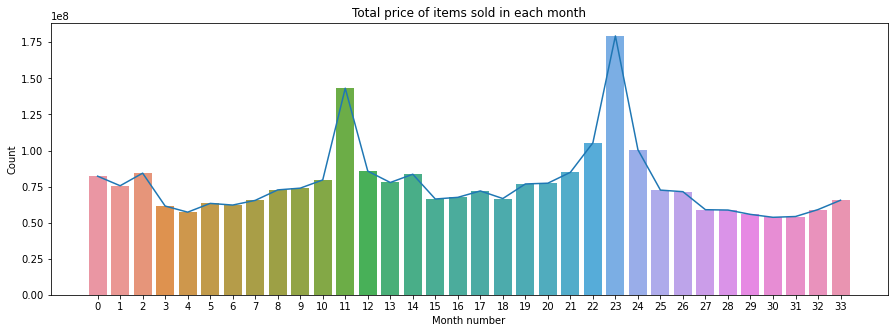

In [24]:
plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

### Correlation between "Number of items sold" and "Total price of all items" in each month

In [25]:
np.corrcoef(item_cnt_month.values, price_cnt_month.values)

array([[1.        , 0.73469191],
       [0.73469191, 1.        ]])

In [26]:
print(items.item_id.nunique())
print(items.item_category_id.nunique())
sales.describe().T

22170
84


,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [27]:
# Impute outliers, price cannot go negative
sales[sales.item_price<0].head(5)
priceimpute=sales[sales.item_price>0].median()
print(priceimpute)

date_block_num      14.0
shop_id             31.0
item_id           9343.0
item_price         399.0
item_cnt_day         1.0
dtype: float64


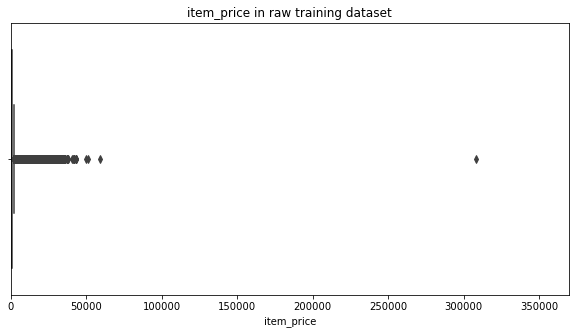

In [28]:
plt.figure(figsize=(10,5))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.2)
plt.title ('item_price in raw training dataset')
sns.boxplot(x=sales.item_price)

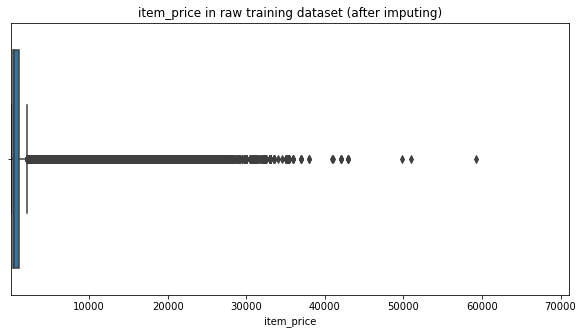

In [29]:
sales.loc[sales.item_price>300000,'item_price']=priceimpute.item_price
sales.loc[sales.item_price<0,'item_price']=priceimpute.item_price
# We also see that items priced 300K is an outlier, impute it with median as well
# impute the data point which has outlier pricing
plt.figure(figsize=(10,5))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.2)
plt.title ('item_price in raw training dataset (after imputing)')
sns.boxplot(x=sales.item_price)

(0.0, 10000.0)

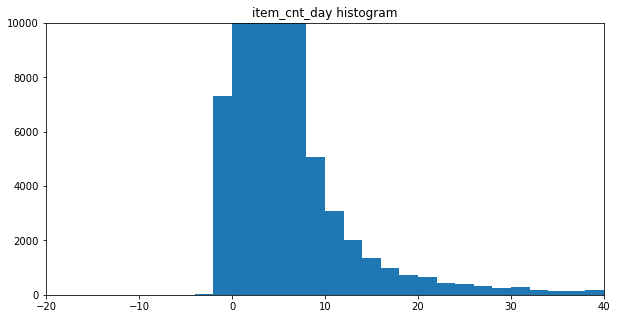

In [30]:
plt.figure(figsize=(10,5))
plt.title ('item_cnt_day histogram')
plt.hist(x=sales.item_cnt_day,bins=np.linspace(-20,40,31))  
# the bins are from -20:2:40 
plt.xlim(-20,40)
plt.ylim(0,1e4)
# We see that a lot of data will need to be trimmed out
# since we are prediction item_cnt_month with data clipped to [0,20], the original data with item_cnt_day>20 will need to be discarded
# for now we do not wish to impute the item_cnt_day.
# we shall trim it after aggregate it by month

In [ ]:
temp=sales
print('total unique items ')
print(temp['item_id'].nunique())
print('\n total unique shops')
print(temp['shop_id'].nunique())
print('\n total unique prices')
print(temp['item_price'].nunique())
print('\n total unique daily sale count')
print(temp['item_cnt_day'].nunique())
print ('\ntheoretical max combination of item,shop,and month')
print(temp['item_id'].nunique()*temp['shop_id'].nunique()*temp['date_block_num'].nunique())
print('\ntraining dataset size is')
print(temp.shape)

### Part 2 Feature Engineering
### Test data - Add date_block_num=34. Because Nov 2015 is block 33+1

In [31]:
test_block = 34
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


### Create grid from all shops/items combinations from that month

In [32]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test_data])

In [ ]:
grid.head()

### Create features by grouping shops, items and month

In [33]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [34]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


### Create features using previous months data - Different lags

In [35]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

<ipython-input-35-212de1725656>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for month_shift in tqdm_notebook(shift_range):


In [ ]:
all_data.head()

### Add "item category id" as a feature

In [36]:
# Don't use old data from year 2013, since we used delay of 12 month. The first 12 months item_cnt_month won't be valid
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
# THIS ENSURES THAT category gets carried over to the all-data dataset  , both training and test
all_data = downcast_dtypes(all_data)

gc.collect()

62

In [68]:
item_category_mapping.head(5)

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [50]:
# More feature engineering - add month and year data
all_data['year'] = all_data['date_block_num'].apply(lambda x: ((x//12) + 2013))
all_data['month']= all_data['date_block_num'].apply(lambda x: (x % 12)+ 1 )

### Final data - Will be used for training and validation

In [ ]:
all_data.head()

In [74]:
to_drop_cols

['target_item', 'target', 'target_shop', 'date_block_num']

### Split data - Train and Test
# Because we have first 12 month raw data discarded, that left us 34-12=22 datasets
# we use 6 of them for validation and 16 of them for initial training
# The plan is to train/validate, then model them, ensemble them, and re-train using combination
# of all train+validation. Then make predictions
# The mean encoding can be done to the respective datasets after split

In [112]:
X_train     =all_data.query('date_block_num>12 and date_block_num<28').copy()
X_validation=all_data.query('date_block_num>=28 and date_block_num<34').copy()
X_test      =all_data.query('date_block_num==34').copy()
all_train   =all_data.query('date_block_num<34').copy()

In [113]:
y_train     = X_train['target'].values
y_validation= X_validation['target'].values
y_test      = X_test['target'].values

X_train     = X_train.drop(to_drop_cols, axis=1)
X_validation= X_validation.drop(to_drop_cols,axis=1)
X_test      = X_test.drop(to_drop_cols, axis=1)


In [121]:
# Mean encoding here
# We have 5 categorical features: year, month, shop_id, item_id and item_category_id
# We should use the combination of train/validation set target mean to encode.

means_shop_id =all_train.groupby('shop_id').target.mean()
means_item_id =all_train.groupby('item_id').target.mean()
means_category=all_train.groupby('item_category_id').target.mean()
means_year    =all_train.groupby('year').target.mean()
means_month   =all_train.groupby('month').target.mean()


In [122]:
X_train['shop_id'+'_mean_target']=X_train['shop_id'].map(means_shop_id)
X_validation['shop_id'+'_mean_target']=X_validation['shop_id'].map(means_shop_id)
all_train['shop_id'+'_mean_target']=all_train['shop_id'].map(means_shop_id)
X_test['shop_id'+'_mean_target']=X_test['shop_id'].map(means_shop_id)

X_train['item_id'+'_mean_target']=X_train['item_id'].map(means_item_id)
X_validation['item_id'+'_mean_target']=X_validation['item_id'].map(means_item_id)
all_train['item_id'+'_mean_target']=all_train['item_id'].map(means_item_id)
X_test['item_id'+'_mean_target']=X_test['item_id'].map(means_item_id)

X_train['category'+'_mean_target']=X_train['item_category_id'].map(means_category)
X_validation['category'+'_mean_target']=X_validation['item_category_id'].map(means_category)
all_train['category'+'_mean_target']=all_train['item_category_id'].map(means_category)
X_test['category'+'_mean_target']=X_test['item_category_id'].map(means_category)

X_train['year'+'_mean_target']=X_train['year'].map(means_year)
X_validation['year'+'_mean_target']=X_validation['year'].map(means_year)
all_train['year'+'_mean_target']=all_train['year'].map(means_year)
X_test['year'+'_mean_target']=X_test['year'].map(means_year)

X_train['month'+'_mean_target']=X_train['month'].map(means_month)
X_validation['month'+'_mean_target']=X_validation['month'].map(means_month)
all_train['month'+'_mean_target']=all_train['month'].map(means_month)
X_test['month'+'_mean_target']=X_test['month'].map(means_month)

X_test.fillna(X_test.mean(), inplace=True)

### Target range - Clip it to [0, 20]

In [123]:
target_range = [0, 20]
target_range

[0, 20]

In [ ]:
# Finally, for test dataset, it does not have mean encoded features. 

## Modelling

### LightGBM method. Here you may manually change what features to use.  Here I did not use mean encoded features - a test that include mean encoded feature end up with lower scores

In [129]:
# Use only part of features on XGBoost. - alternatively , use X_train.columns to include all features
lgb_features = (['shop_id', 'item_id', 'target_lag_1', 'target_item_lag_1',
       'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2',
       'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3',
       'target_shop_lag_3', 'target_lag_12', 'target_item_lag_12',
       'target_shop_lag_12', 'item_category_id', 'year', 'month'])
lgb_train = X_train[lgb_features]
lgb_validation=X_validation[lgb_features]
lgb_test= X_test[lgb_features]

In [132]:
lgb_train.head().T

,347346,347347,347348,347349,347350
shop_id,27.0,27.0,27.0,27.0,27.0
item_id,15242.0,15200.0,15279.0,15202.0,14888.0
target_lag_1,1.0,0.0,2.0,0.0,2.0
target_item_lag_1,9.0,1.0,48.0,2.0,21.0
target_shop_lag_1,5451.0,5451.0,5451.0,5451.0,5451.0
target_lag_2,1.0,0.0,3.0,0.0,0.0
target_item_lag_2,28.0,1.0,52.0,15.0,32.0
target_shop_lag_2,7983.0,7983.0,7983.0,7983.0,7983.0
target_lag_3,0.0,0.0,0.0,0.0,1.0
target_item_lag_3,10.0,0.0,0.0,5.0,44.0


In [130]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

#model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
lgb_model = lgb.train(lgb_params, lgb.Dataset(lgb_train, label=y_train), 100)

Y_train_lgb=lgb_model.predict(lgb_train).clip(*target_range)
Y_validation_lgb=lgb_model.predict(lgb_validation).clip(*target_range)
Y_test_lgb=lgb_model.predict(lgb_test).clip(*target_range)
print('Training RMSE',np.sqrt(mean_squared_error(y_train, Y_train_lgb)))
print('Validation RMSE',np.sqrt(mean_squared_error(y_validation, Y_validation_lgb)))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training RMSE 3.163164873146352
Validation RMSE 4.01138358304238


In [133]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': Y_test_lgb})
submission.to_csv('Predictions/submission_lgb027morning3.csv', index=False)
# I have attempted submitting it and got score 8/10 for this method alone. 

### XGBoost Next
### We expect to see similar scores compare with lightgbm

In [142]:
xgb_features=['item_category_id','item_id','shop_id','month','target_lag_1','target_lag_2','target_lag_3','target_shop_lag_1','target_item_lag_1']
xgb_train = X_train[xgb_features]
xgb_validation = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [143]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train),(xgb_validation, y_validation)],  # (xgb_val, Y_validation) 
              verbose=20, 
              early_stopping_rounds=10)

[0]	validation_0-rmse:3.26343	validation_1-rmse:4.04188
[20]	validation_0-rmse:2.89351	validation_1-rmse:3.84161
[22]	validation_0-rmse:2.88868	validation_1-rmse:3.83780


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='approx', validate_parameters=1,
             verbosity=None)

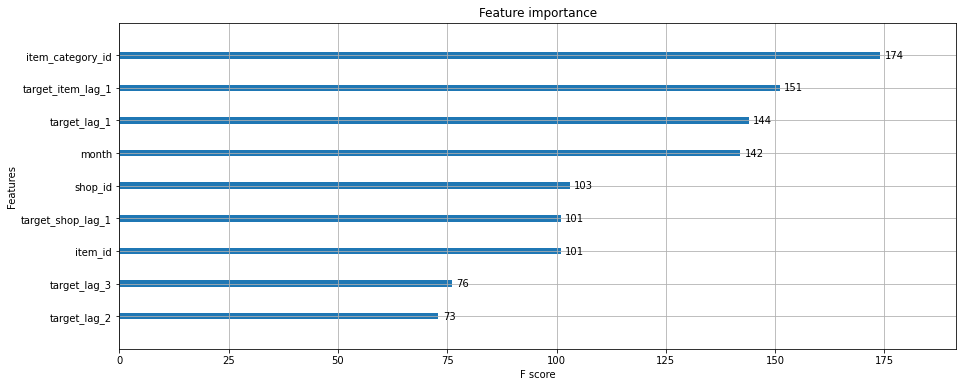

In [144]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [145]:
Y_train_xgb = xgb_model.predict(xgb_train)
Y_validation_xgb   = xgb_model.predict(xgb_validation)
Y_test_xgb  = xgb_model.predict(xgb_test)
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': Y_test_xgb})
submission.to_csv('Predictions/submission_xgb0927morning3.csv', index=False)

### Ensemble at the second level - 
Step1:  combine the validation predictions from all these 2 learners, and create a label that corresponds to the validation set target
This serves as the meta data (meta of target);
Step2: create a test dataset by similar methods, using test dataset prediction
Step3: train meta model linearly (second level is lr): The meta model without target is the input, validation target as target
Step4: use the retrained model3, use test dataset at step2 as input, make final prediction.
we can check rmse of final prediction vs. validation set

In [150]:
# Step1
Firstlevel=pd.DataFrame(Y_validation_lgb,columns=['lgb'])
Firstlevel['xgb']=Y_validation_xgb   
Firstlevel['Target']=y_validation                     
Firstlevel.head(5)

,lgb,xgb,Target
0,0.355508,0.151579,2.0
1,0.077210,0.063644,1.0
2,0.108411,0.106434,1.0
3,0.479284,0.528888,2.0
4,1.480797,0.849134,2.0


In [151]:
# step 2
Firstlevel_test       =pd.DataFrame(Y_test_lgb,columns=['lgb'])
Firstlevel_test['xgb'] =Y_test_xgb                      
Firstlevel.head(5)

,lgb,xgb,Target
0,0.355508,0.151579,2.0
1,0.077210,0.063644,1.0
2,0.108411,0.106434,1.0
3,0.479284,0.528888,2.0
4,1.480797,0.849134,2.0


In [152]:
# step 3 
Metalrmodel = LinearRegression(n_jobs=-1)
Firstlevel.drop('Target', axis=1, inplace=True)
Metalrmodel.fit(Firstlevel, y_validation)

LinearRegression(n_jobs=-1)

In [153]:
# Step 4
Ensemble_validation_lr=Metalrmodel.predict(Firstlevel).clip(*target_range)
Ensemble_test_lr      =Metalrmodel.predict(Firstlevel_test).clip(*target_range)
print('Train rmse:', np.sqrt(mean_squared_error(Ensemble_validation_lr, y_validation)))

Train rmse: 4.009200894061403


In [154]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': Ensemble_test_lr})
submission.to_csv('Predictions/submission_Ensemble09272021morning.csv', index=False)

### Conclusion
- item category feature is the key to good prediction - although it was not provided at test set
- mean encoding sometimes failed to improve fit
- ensembling can be tricky sometimes. Simple weighted averaging might work better than stacking
- need to pay attention to data leakage - here the test set has values never appeared in raw training set, requires EDA carefully